### Introduction

<hr/>

- In binary classification, we predict if the output is either 0 or 1 (e.g., not-cat or cat).
- To output a discrete value (i.e., 0 and 1), we need to use an algorithm called **Logistic Regression**, which basically is $sigmoid(\text{Linear Regression})$.
- To train the weights $w$ and bias $b$, we use the **Binary Cross-Entropy Loss** (a.k.a. Log Loss). The cost is simply computed by averaging the sum over all losses by the number of training examples.
- We train the model by minimizing this cost using an optimization algorithm like **Gradient Descent**. 

### Problem Statement: Cat Classification

<hr/>

- Given a dataset of 6 cats and 6 dogs, train the model on 5 cats and 5 dogs, make prediction on the 6<sup>th</sup> cat and 6<sup>th</sup> dog.
- The dataset can be found at `./data/binary_classification/`.

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

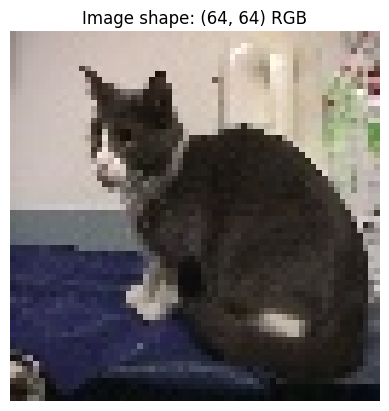

In [2]:
# View the data

root_dir = r"data/binary_classification/"
cat_dir = root_dir + "cat/"
dog_dir = root_dir + "dog/"

cat_img_names, dog_img_names = os.listdir(cat_dir), os.listdir(dog_dir)
cat_id = 4  # Change as you wish, from 0 to 5
cat_img = Image.open(cat_dir + cat_img_names[cat_id])

plt.imshow(cat_img)
plt.title(f"Image shape: {cat_img.size} {cat_img.mode}")
plt.axis("off")
plt.show()

In [3]:
# Prepare the dataset with torchvision.datasets.ImageFolder

"""
- ImageFolder is a built-in PyTorch dataset class specifically designed for image classification tasks where the images are organized in subdirectories.
- This class helps automatically labeling images 
"""

from torchvision import datasets, transforms

class CatAndDogDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
    
    def __getitem__(self, index):
        # Get the original image and its label from ImageFolder
        image, label = super().__getitem__(index)
        
        # Modify labels (swap the labels if you want 'cat' to be 1 and 'dog' to be 0)
        if label == 0:  # 'cat' folder
            label = 1
        elif label == 1:  # 'dog' folder
            label = 0
        
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to tensor
])

# Use the custom dataset class to load the data
dataset = CatAndDogDataset(root=root_dir, transform=transform)

In [4]:
# Get some insights about the dataset

print(f"We have {len(dataset)} images, with {len([img for img, label in dataset if label == 1])} cats and {len([img for img, label in dataset if label == 1])} dogs.")

cat_imgs = [img for img, label in dataset if label == 1]
dog_imgs = [img for img, label in dataset if label == 0]
print(f"The first cat image has the shape of {cat_imgs[0].shape}")
print(f"The first dog image has the shape of {dog_imgs[0].shape}")

We have 12 images, with 6 cats and 6 dogs.
The first cat image has the shape of torch.Size([3, 64, 64])
The first dog image has the shape of torch.Size([3, 64, 64])


In [5]:
# Get the training dataset of 10 images only

from torch.utils.data import DataLoader, Subset
# Create a subset with the manually selected images
train_indices = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
train_dataset = Subset(dataset, train_indices)

# Create DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [6]:
# Create our binary classifier

import torch
import torch.nn as nn

class CatClassifier(nn.Module):

    def __init__(self, input_size):
        super(CatClassifier, self).__init__()

        self.fc1 = nn.Linear(in_features=input_size, out_features=50)  # First hidden layer
        self.fc2 = nn.Linear(in_features=50, out_features=50)  # Second hidden layer
        self.fc3 = nn.Linear(in_features=50, out_features=1)  # Output layer
        
        # Define an activation function (ReLU for hidden layers)
        self.relu = nn.ReLU()
        # Define a sigmoid activation for the output layer (binary classification)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [7]:
# Train our model

import torch.optim as optim

# Create a model
INPUT_SIZE = 3 * 64 * 64
model = CatClassifier(input_size=INPUT_SIZE)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.001)  # Gradient Descent
num_epochs = 500
history = list()

for i in range(num_epochs):
    epoch_loss = 0
    
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs.squeeze(), labels.float().squeeze())  # labels should be float for BCELoss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(train_loader)
    history.append(epoch_loss)
    
    if i % 50 == 0:
        print(f"Epoch {i}: Loss = {epoch_loss}")


Epoch 0: Loss = 0.707790195941925
Epoch 50: Loss = 0.4778949975967407
Epoch 100: Loss = 0.14049871377646922
Epoch 150: Loss = 0.044920626748353246
Epoch 200: Loss = 0.02198205585591495
Epoch 250: Loss = 0.013480176473967731
Epoch 300: Loss = 0.009336829022504389
Epoch 350: Loss = 0.00696406631032005
Epoch 400: Loss = 0.005495668255025521
Epoch 450: Loss = 0.004490053321933374


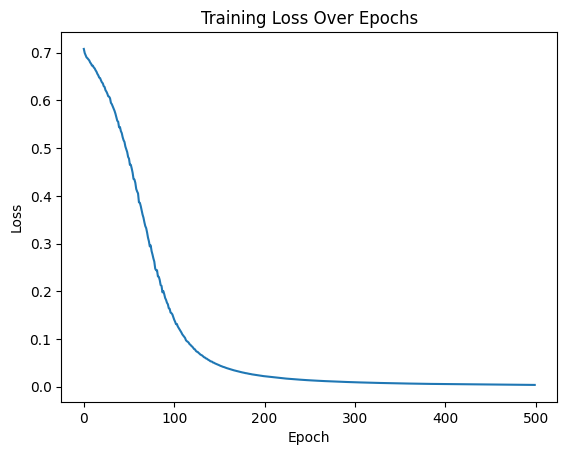

In [8]:
# Plotting the training loss

plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

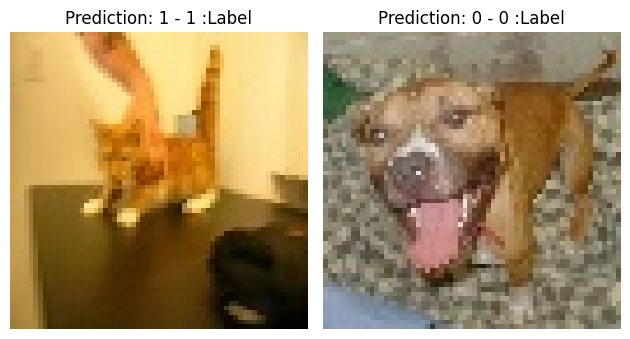

In [9]:
# Test our model on the 2 other images

# Create test dataset
test_indices = [0, 6]
test_dataset = Subset(dataset, test_indices)

# Create test_loader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Set the model to evaluation mode
model.eval()
predictions = list()

for image, label in test_loader:
    # Disable gradient computation during prediction
    with torch.no_grad():
        output = model(image)
        predicted_label = 1 if output.item() >= 0.5 else 0  # Threshold the prediction (e.g., 0.5)
        predictions.append([predicted_label, label.item()])

# Show the images
cat_id, dog_id = test_indices
cat_img = Image.open(cat_dir + cat_img_names[cat_id])
dog_img = Image.open(dog_dir + dog_img_names[dog_id-6])

# Set up the figure
plt.figure() 

# Display the cat image
plt.subplot(1, 2, 1)
plt.imshow(cat_img)
plt.title(f"Prediction: {predictions[0][0]} - {predictions[0][1]} :Label")
plt.axis("off")

# Display the dog image
plt.subplot(1, 2, 2)
plt.imshow(dog_img)
plt.title(f"Prediction: {predictions[1][0]} - {predictions[1][1]} :Label")
plt.axis("off")

# Show the images
plt.tight_layout()
plt.show()

### About the Logistic Regression Algorithm

<hr/>

- In essence, Logistic Regression is a function (i.e., takes an input and gives an output).
- This function is defined as $\hat{y}=\sigma(z)$ with $z$ being $w^{T} x + b$. (N.B. $\hat{y}$ is the prediction, $x, w, b$ is the input vector, weights and bias.)
- The $sigmoid$ function $\sigma(z)$ ranges from 0 to 1 and is defined as $$\sigma(z) = \frac{1}{1 + e^{-z}}$$

### About the Log Loss

<hr/>

- The purpose of a loss in Machine Learning is to assess how accurate a prediction is to the true value.
- If the loss value is small, it indicates accurate prediction and vice versa.
- The Log Loss $L(\hat{y}, y)$ is defined as $$L(\hat{y}, y) = -(y\log(\hat{y}) + (1-y)\log(1-\hat{y}))$$
- Expectedly, the cost function is defined as $$J(w, b) = \frac{1}{m}\sum_{i=1}^{m}L(\hat{y}^{i}, y^{i})$$

### About Gradient Descent

<hr/>

- We use Gradient Descent (GD) as an optimization algorithm to find $w, b$ that minimize the cost $J(w, b)$.
- GD works by subtracting $w$ and $b$ with the first derivative of $J(w, b)$ with respect to $w$ and $b$ so that the cost $J(w, b)$ decreases (in other words, heads to its global minima).
- More specifically, $$w = w - \alpha \frac{\partial J(w, b)}{\partial w}$$ $$b = b - \alpha \frac{\partial J(w, b)}{\partial b}$$
- N.B. Repeat this process for a desired number of times, with $\alpha$ being the learning rate.